<a href="https://colab.research.google.com/github/fibleep/michael-cera-detector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import tarfile
import numpy as np
from urllib import request
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


base_path = "/content/sample_data/CV__Group_assignment"

if not os.path.isdir(base_path):
  os.makedirs(base_path)

trained_haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

with request.urlopen(trained_haarcascade_url) as r, open(os.path.join(base_path, "haarcascade_frontalface_default.xml"), 'wb') as f:
    f.write(r.read())

# Implementing Transfer Learning for Michael Cera detection

Get the dataset

In [2]:
!git clone https://github.com/fibleep/michael-cera-detector.git

fatal: destination path 'michael-cera-detector' already exists and is not an empty directory.


In [3]:
import keras
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

directory = '/content/michael-cera-detector/dataset'

# Keras Image Data Generator with augmentation
augment_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize the pixels
    rotation_range=20,      # Degree range for random rotations
    width_shift_range=0.2,  # Range for random horizontal shifts
    height_shift_range=0.2, # Range for random vertical shifts
    shear_range=0.2,        # Shear angle in counter-clockwise direction
    zoom_range=0.2,         # Random zoom range
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)

normal_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 128 # How many images loaded in at once, in this case we load in everything
target_size = (224, 224)  # Image dimensions

# Create a generator for reading images from the directory
train_imgs = normal_datagen.flow_from_directory(
    directory + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

train_imgs_augmented = augment_datagen.flow_from_directory(
    directory + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_imgs = normal_datagen.flow_from_directory(
    directory + "/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 35 images belonging to 2 classes.
Found 35 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# Extract Faces

In [4]:
import numpy as np

def get_all_images_and_labels_combined(normal_gen, augmented_gen):
    def extract_data(generator):
        num_samples = generator.samples
        data_size = num_samples // batch_size + (1 if num_samples % batch_size else 0)

        all_imgs = None
        all_labels = None

        for i in range(data_size):
            imgs, labels = next(generator)
            if all_imgs is None:
                all_imgs = imgs
                all_labels = labels
            else:
                all_imgs = np.concatenate((all_imgs, imgs))
                all_labels = np.concatenate((all_labels, labels))

        return all_imgs, all_labels

    normal_imgs, normal_labels = extract_data(normal_gen)
    augmented_imgs, augmented_labels = extract_data(augmented_gen)

    combined_imgs = np.concatenate((normal_imgs, augmented_imgs))
    combined_labels = np.concatenate((normal_labels, augmented_labels))

    return combined_imgs, combined_labels


combined_train_imgs, combined_train_labels = get_all_images_and_labels_combined(train_imgs, train_imgs_augmented)


Found 1 face(s)!


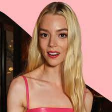

Found 0 face(s)!


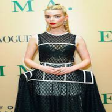

Found 0 face(s)!


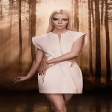

Found 1 face(s)!


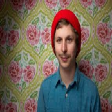

Found 1 face(s)!


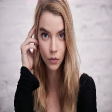

Found 1 face(s)!


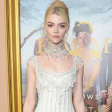

Found 1 face(s)!


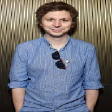

Found 1 face(s)!


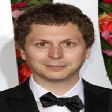

Found 1 face(s)!


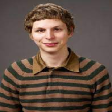

Found 1 face(s)!


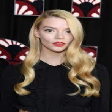

Found 1 face(s)!


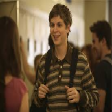

Found 1 face(s)!


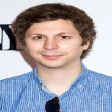

Found 1 face(s)!


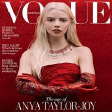

Found 1 face(s)!


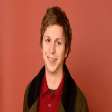

Found 1 face(s)!


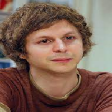

Found 1 face(s)!


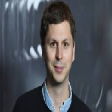

Found 1 face(s)!


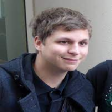

Found 1 face(s)!


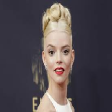

Found 0 face(s)!


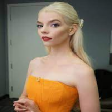

Found 2 face(s)!


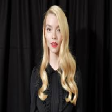

Found 0 face(s)!


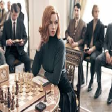

Found 1 face(s)!


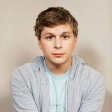

Found 1 face(s)!


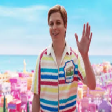

Found 1 face(s)!


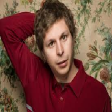

Found 1 face(s)!


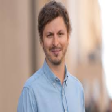

Found 1 face(s)!


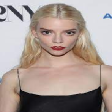

Found 0 face(s)!


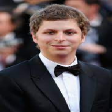

Found 2 face(s)!


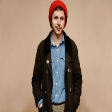

Found 0 face(s)!


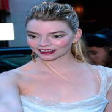

Found 0 face(s)!


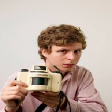

Found 1 face(s)!


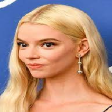

Found 1 face(s)!


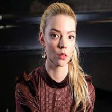

Found 0 face(s)!


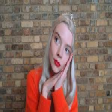

Found 1 face(s)!


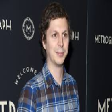

Found 1 face(s)!


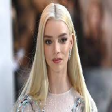

Found 1 face(s)!


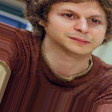

Found 0 face(s)!


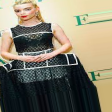

Found 1 face(s)!


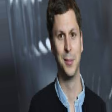

Found 1 face(s)!


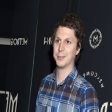

Found 1 face(s)!


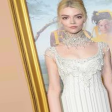

Found 0 face(s)!


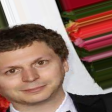

Found 1 face(s)!


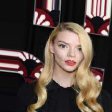

Found 0 face(s)!


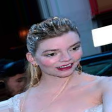

Found 1 face(s)!


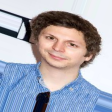

Found 1 face(s)!


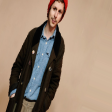

Found 1 face(s)!


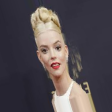

Found 1 face(s)!


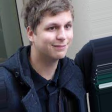

Found 0 face(s)!


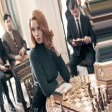

Found 0 face(s)!


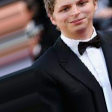

Found 1 face(s)!


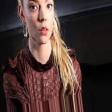

Found 1 face(s)!


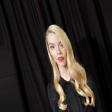

Found 0 face(s)!


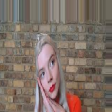

Found 0 face(s)!


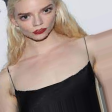

Found 1 face(s)!


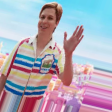

Found 1 face(s)!


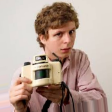

Found 1 face(s)!


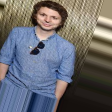

Found 1 face(s)!


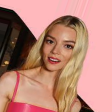

Found 1 face(s)!


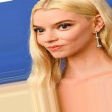

Found 1 face(s)!


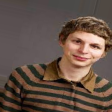

Found 1 face(s)!


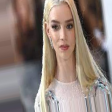

Found 0 face(s)!


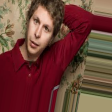

Found 1 face(s)!


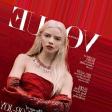

Found 1 face(s)!


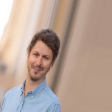

Found 0 face(s)!


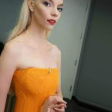

Found 1 face(s)!


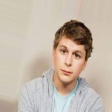

Found 0 face(s)!


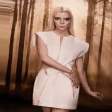

Found 0 face(s)!


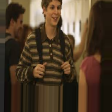

Found 1 face(s)!


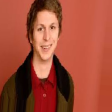

Found 1 face(s)!


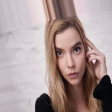

Found 1 face(s)!


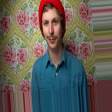

In [5]:
faceCascade = cv2.CascadeClassifier(os.path.join(base_path, "haarcascade_frontalface_default.xml"))

X = []
Y = []

for img,label in zip(combined_train_imgs, combined_train_labels):
    img = (img * 255).astype(np.uint8)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_gray = img.copy()
    faces = faceCascade.detectMultiScale(
        img_gray,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    print("Found {} face(s)!".format(len(faces)))
    img_resized = cv2.resize(img, (224, 224))
    X.append(img_resized)
    Y.append(label)

    for (x, y, w, h) in faces:
        face = img_[y:y+h, x:x+w]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        X.append(face)
        Y.append(label)
        break

    h, w = img_.shape[:2]

    cv2_imshow(cv2.resize(img_, (w // 2, h // 2)))

In [6]:
# for face, one_hot_label in zip(X, Y):
#     plt.imshow(face)
#     plt.title(one_hot_label)
#     plt.show()

# Augment Data

In [7]:
import tensorflow as tf
image_iterator = augment_datagen.flow(np.array(X), np.array(Y), batch_size=128)

# Train Model

In [8]:
import tensorflow as tf
from tensorflow import keras

base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=None
)

for layer in base_model.layers:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [9]:
test_images, test_labels = test_imgs[0]

test_X = []
test_Y = []

for image, label in zip(test_images, test_labels):
  test_X.append(image)
  test_Y.append(label)

In [10]:

def plot_image_grid(images, labels, rows, cols, title):
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [11]:

# plot_image_grid(np.array(test_X), np.array(test_Y), rows=4, cols=5, title="Test Dataset Images")

# plot_image_grid(np.array(X), np.array(Y), rows=4, cols=5, title="Training Dataset Images")


In [12]:
# X, Y = next(image_iterator)

# for image,label in zip(np.array(X), np.array(Y)):
#     plt.imshow(image)
#     plt.title(label)
#     plt.show()

In [13]:

print(Y)

[array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([0., 1.], dtype=float32), array([

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
import keras




train_batch = next(train_imgs)
test_batch = next(test_imgs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

epochs = 50
model.fit(image_iterator, epochs=epochs, validation_data=(np.array(test_X), np.array(test_Y)))

Epoch 1/50
1/1 [==============================] - 36s 36s/step - loss: 0.8159 - accuracy: 0.5702 - val_loss: 0.9170 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.9163 - accuracy: 0.5785 - val_loss: 0.9361 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 0.8047 - accuracy: 0.6529 - val_loss: 1.0489 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.8956 - accuracy: 0.5620 - val_loss: 1.4283 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.8470 - accuracy: 0.5868 - val_loss: 1.6750 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 0.8159 - accuracy: 0.6116 - val_loss: 1.9411 - val_accuracy: 0.5000
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.7233 - accuracy: 0.6033 - val_loss: 2.3102 - val_accuracy: 0.5000
Epoch 8/50
1/1 [=======================

In [15]:
test_Y

[array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32)]

In [20]:
test_batch = next(test_imgs)
predictions = model.predict(test_batch[0])
predictions

1/1 [==============================] - 0s 29ms/step


array([[9.9997306e-01, 2.6999771e-05],
       [1.0000000e+00, 7.6626622e-12],
       [1.5417617e-03, 9.9845827e-01],
       [7.7740413e-01, 2.2259590e-01],
       [5.5965555e-01, 4.4034442e-01],
       [1.8706557e-04, 9.9981290e-01],
       [1.0000000e+00, 2.0101921e-12],
       [1.2678755e-02, 9.8732126e-01],
       [9.9999988e-01, 9.4451565e-08],
       [9.4315124e-01, 5.6848764e-02],
       [1.1287244e-07, 9.9999988e-01],
       [1.0000000e+00, 5.6527643e-20],
       [1.0000000e+00, 8.7435560e-13],
       [7.3707330e-01, 2.6292664e-01],
       [1.4223987e-07, 9.9999988e-01],
       [1.0000000e+00, 1.0785407e-08],
       [2.9928824e-06, 9.9999702e-01],
       [9.8143989e-01, 1.8560084e-02],
       [7.2676080e-06, 9.9999273e-01],
       [1.0000000e+00, 9.1757512e-15]], dtype=float32)

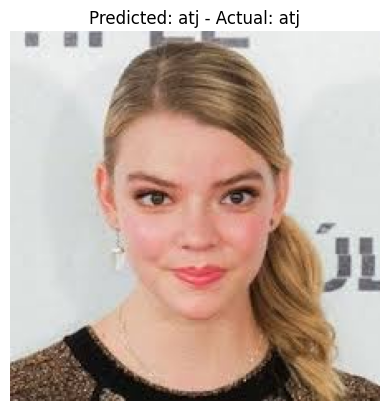

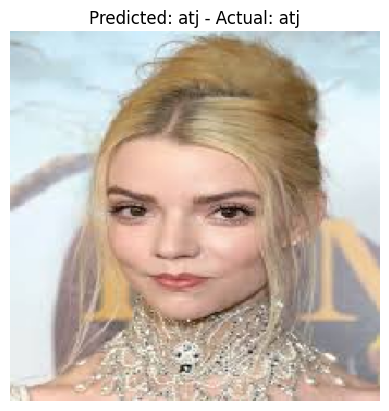

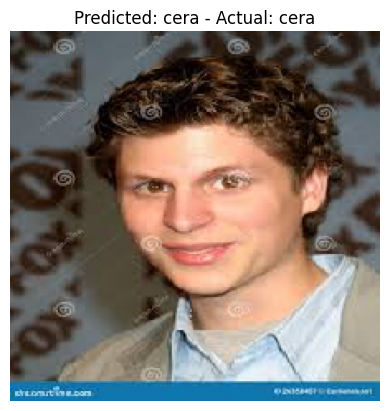

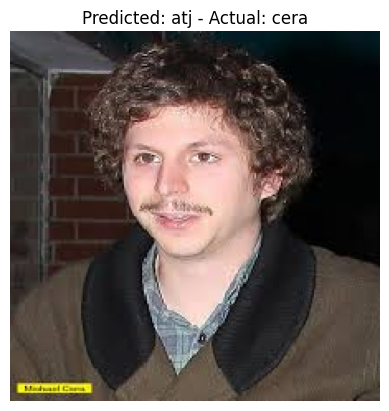

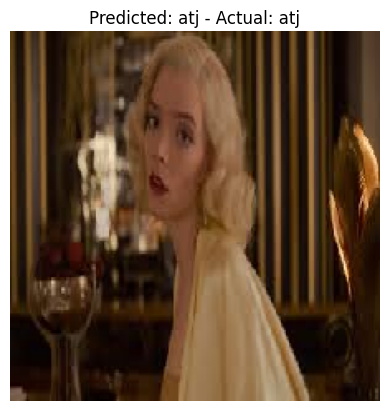

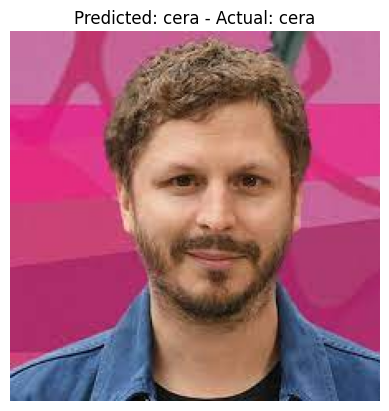

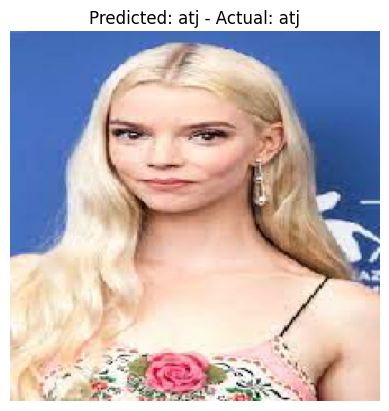

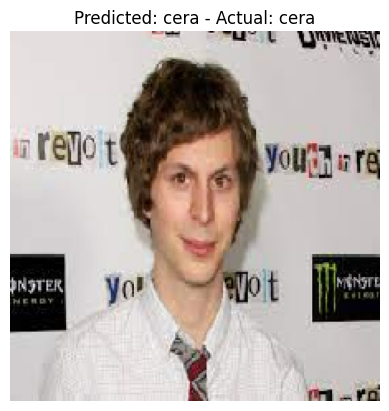

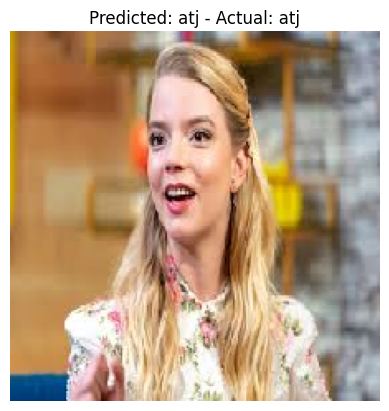

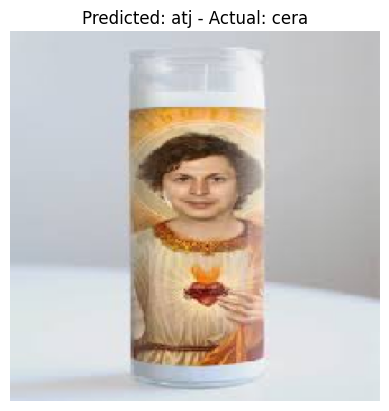

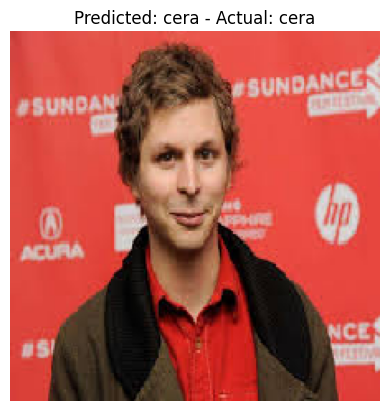

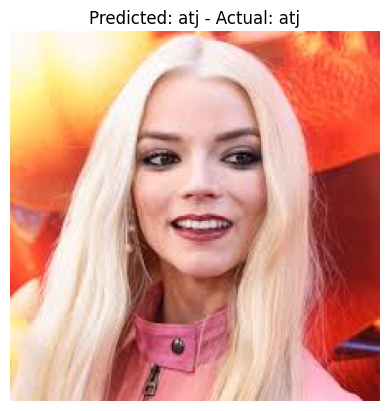

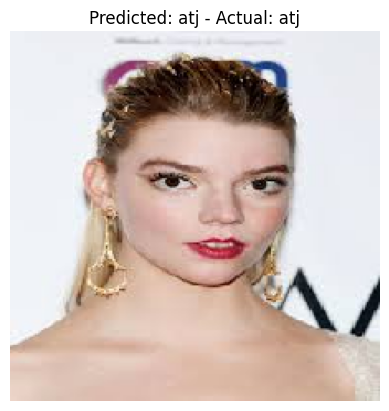

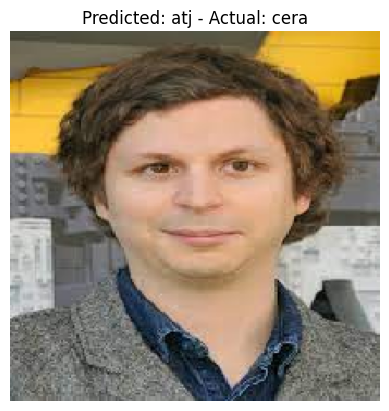

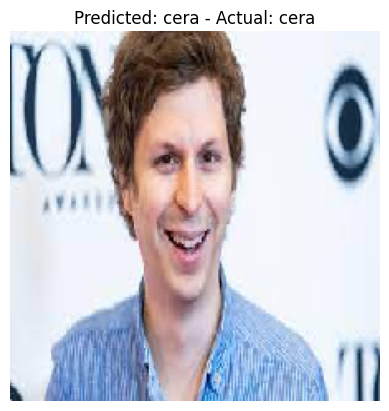

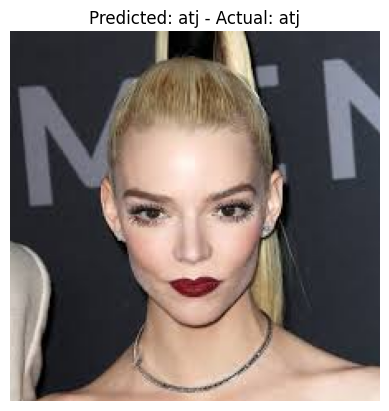

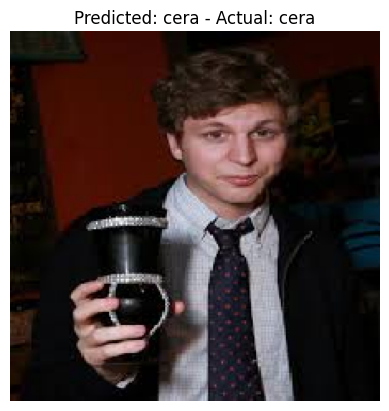

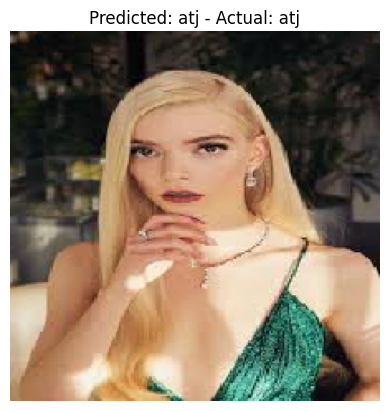

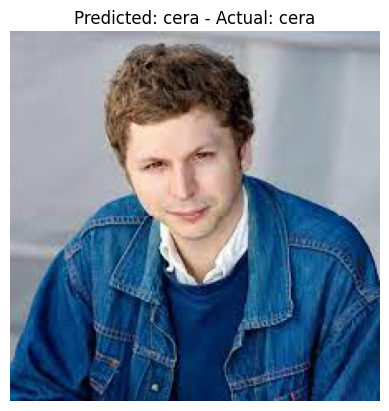

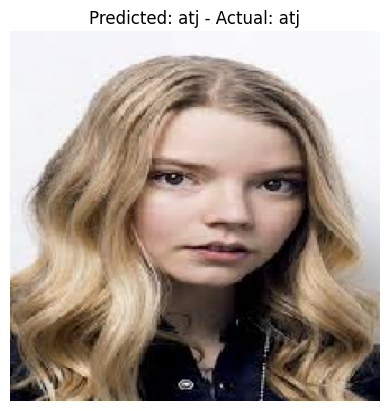

In [21]:
class_labels = ["atj","cera"]
import matplotlib.pyplot as plt
for idx, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]
    true_label =class_labels[np.argmax(test_batch[1][idx])]
    plt.imshow(test_batch[0][idx])
    plt.title(f"Predicted: {predicted_label} - Actual: {true_label}")
    plt.axis('off')
    plt.show()

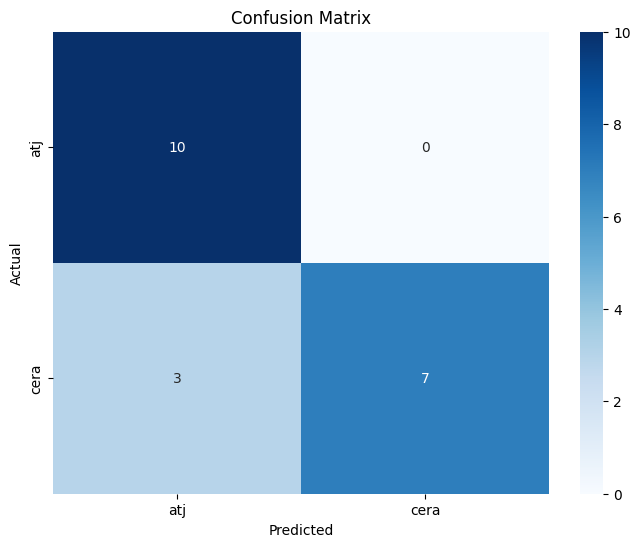

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
predicted_labels = []

for idx, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]
    true_label = class_labels[np.argmax(test_batch[1][idx])]

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)


label_to_num = {label: num for num, label in enumerate(class_labels)}
num_true_labels = [label_to_num[label] for label in true_labels]
num_predicted_labels = [label_to_num[label] for label in predicted_labels]
cm = confusion_matrix(num_true_labels, num_predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Found 16 images belonging to 2 classes.
1/1 [==============================] - 0s 35ms/step


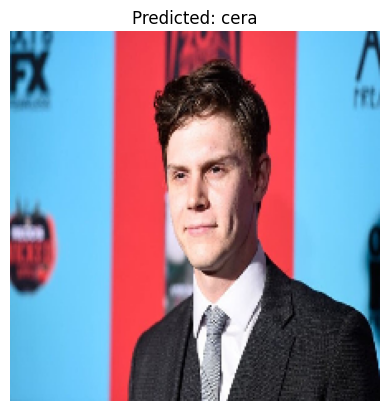

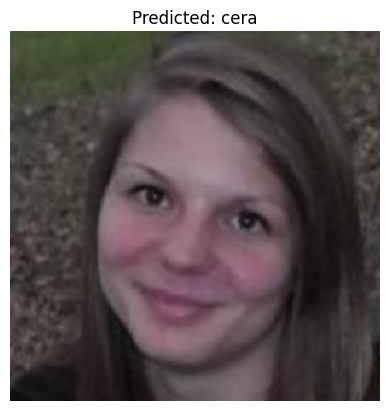

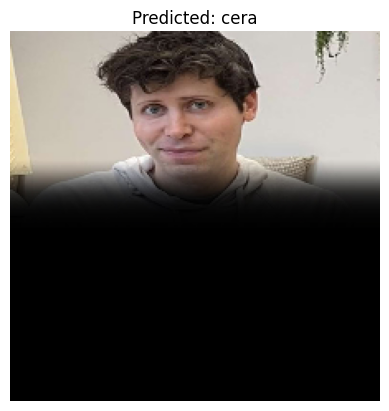

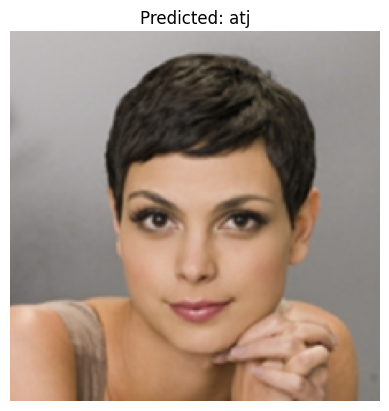

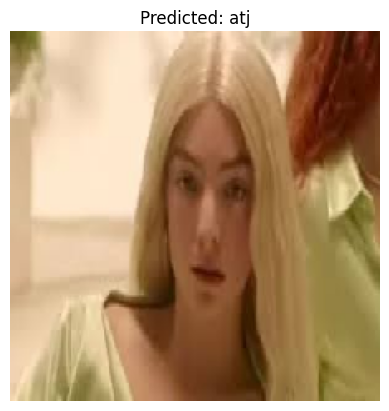

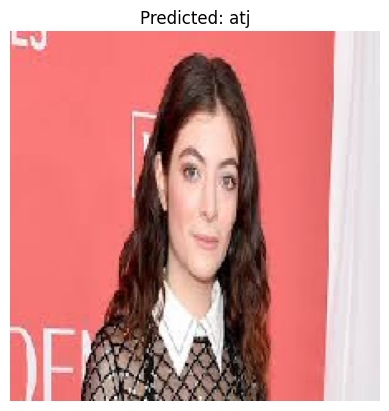

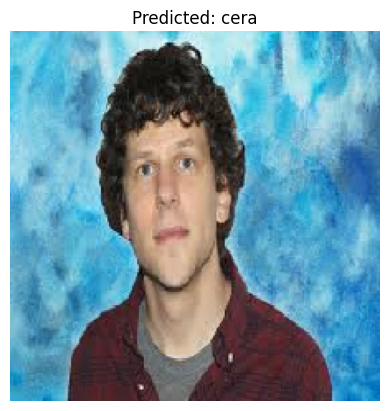

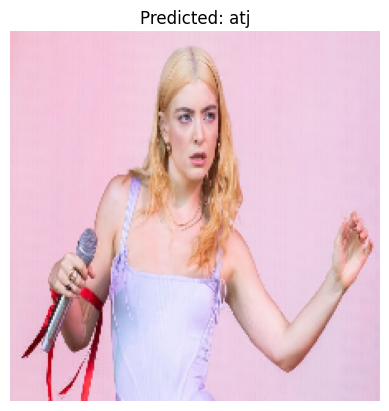

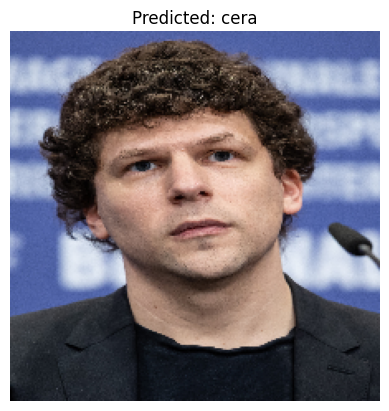

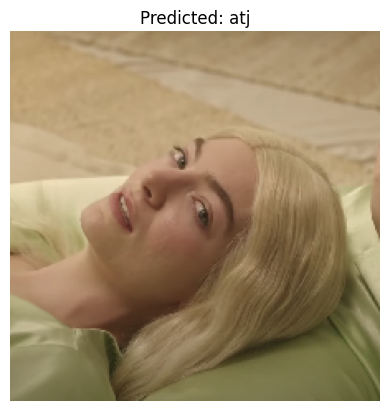

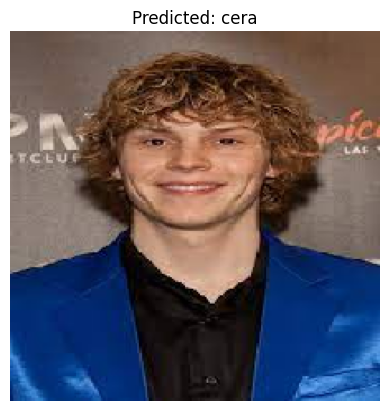

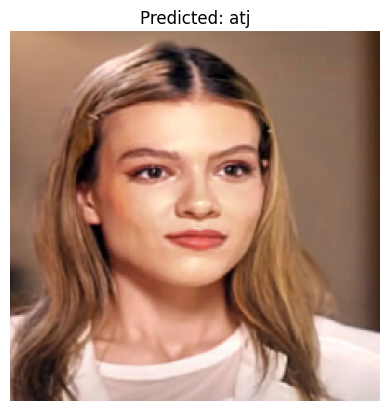

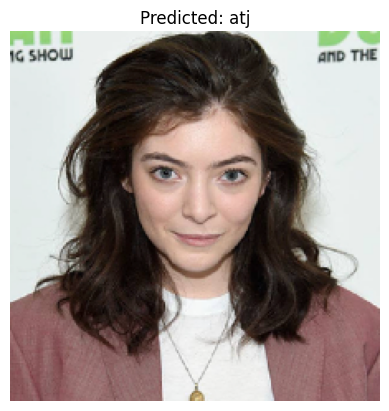

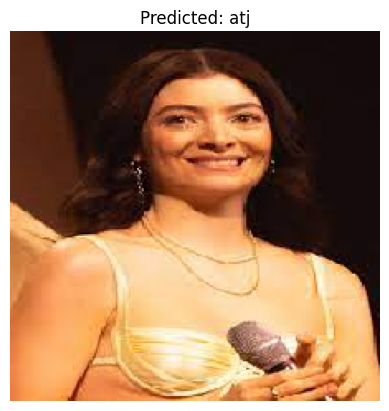

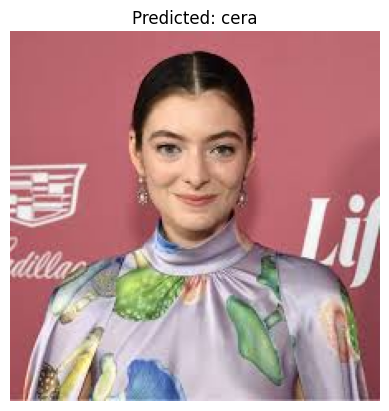

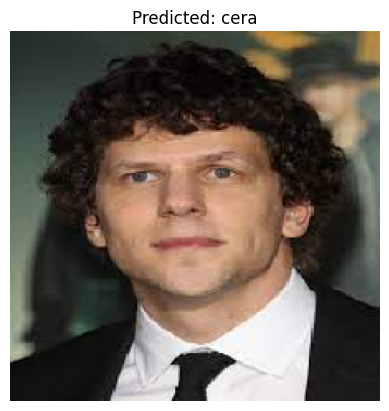

In [24]:
val_imgs = normal_datagen.flow_from_directory(
    directory + "/val",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_batch = next(val_imgs)
predictions = model.predict(val_batch[0])
val_class_labels = list(val_imgs.class_indices.keys())


for idx, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]
    plt.imshow(val_batch[0][idx])
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

The classifier recognizes male from female pretty well, sometimes hiccups on blonde lorde